# Lendingkart

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 500
pio.renderers.default = "png"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/lendingkart/lendingkart.csv')

In [3]:
# Company username
company_username = 'Lendingkart'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(1124, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 736


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [70]:
result_list = []
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result_list.append([conversation_id, response_time])

result = pd.DataFrame(result_list, columns=['conversation_id', 'response_time'])

In [71]:
result[result['response_time']==0]

,conversation_id,response_time


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



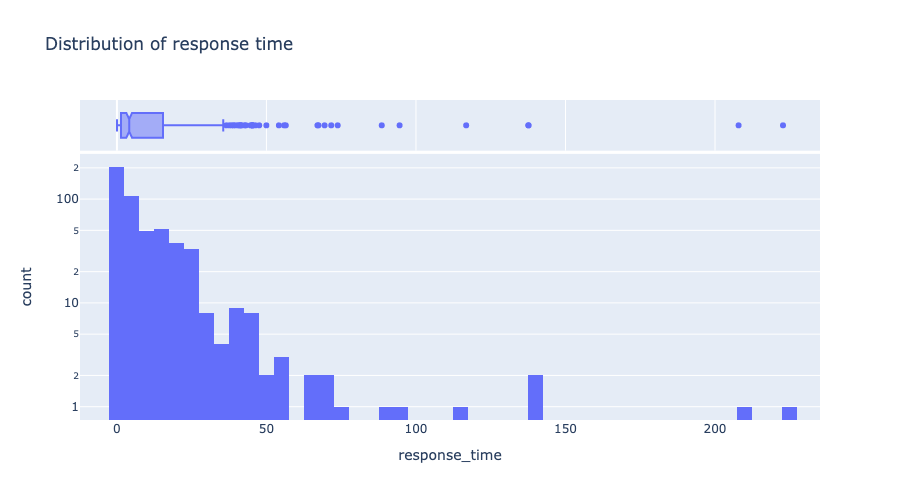

In [80]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [73]:
result['resolution_time'] = 0

In [75]:
unresolved_queries_count = 0
for index, row in result.iterrows():
    tmp = df[df['conversation_id'] == row['conversation_id']]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[0]['username'] != company_username:
        if tmp.iloc[-1]['username'] == company_username:
            resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
            result.at[index, 'resolution_time'] = resolution_time

In [76]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 477
Number of queries unresolved: 53


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



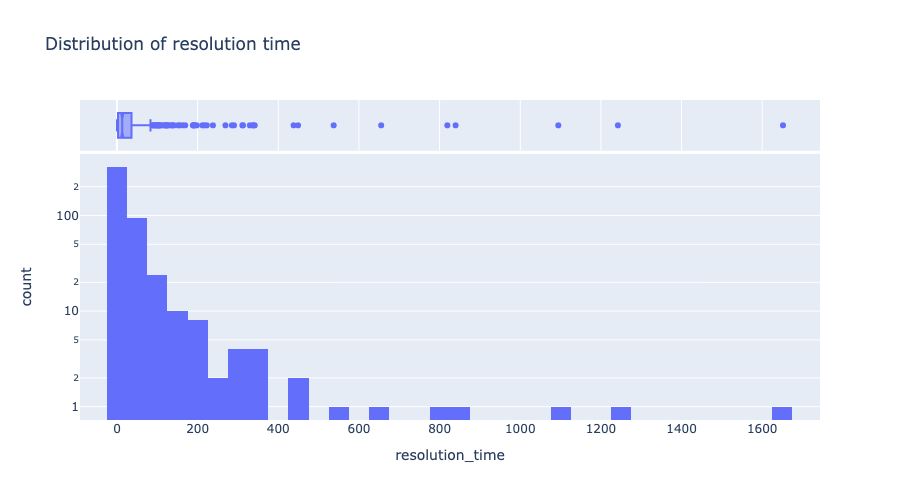

In [81]:
fig = px.histogram(result[(result['resolution_time']!=0) & (result['resolution_time']<2000)], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [83]:
result.describe()

,response_time,resolution_time
count,530.000000,530.000000
mean,22.071586,53.474592
std,241.024484,271.836336
min,0.030833,0.000000
25%,1.364028,1.424653
50%,4.144028,9.897639
75%,15.458125,29.559375
max,5540.252222,5540.254722


In [82]:
result.to_csv('./../../../../outputs/time_data/lendingkart.csv', index=False)

## Query Tweets Topics

In [21]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]

In [22]:
queries.shape

(512, 28)

In [23]:
processor = Processor('./../../data/config.json')

In [24]:
# queries = processor.preprocess_individual(queries)
pre_queries, post_queries = processor.preprocess(queries)

In [25]:
# Create dictionaries
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())

In [26]:
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]

In [27]:
pre_queries.shape

(26, 31)

In [28]:
post_queries.shape

(440, 31)

In [29]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')

In [30]:
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -14.372520693896256


In [31]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064533  0.070092       1        1  41.002520
2     -0.098793  0.015948       2        1  39.292019
1      0.034260 -0.086039       3        1  19.705461, topic_info=         Term      Freq     Total Category  logprob  loglift
49    service  2.000000  2.000000  Default  30.0000  30.0000
51   customer  3.000000  3.000000  Default  29.0000  29.0000
48         rd  1.000000  1.000000  Default  28.0000  28.0000
46      class  1.000000  1.000000  Default  27.0000  27.0000
32       loan  9.000000  9.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
65    request  0.601974  1.629376   Topic3  -4.5770   0.6285
47        ill  0.601827  1.629424   Topic3  -4.5772   0.6283
4        guys  0.600714  1.620520   Topic3  -4.5791   0.6319
98   rejected  0.600539  2.239415   Topic3  -4.5794   0.3081
97  receiving  0.600493  1.629908   Topic3  -4.5795   0.6257

[149 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
130       2  0.855250       account
150       1  0.848430         agent
67        1  0.860007   application
67        3  0.286669   application
93        3  0.988951  applications
...     ...       ...           ...
128       3  0.988741      whatsapp
100       3  0.989009          wont
129       3  0.988741          work
45        2  0.855351         worst
205       1  0.848463         youre

[138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [32]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())

# pre_queries_topic_sents_keywords.dropna(axis=0, inplace=True)

In [33]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['loan, know, gaurav, disbursal, start, let, approved, docs, cheque, dsa',
       'service, customer, rd, class, email, number, happen, request, ill, benny',
       'loan, application, team, id, business, time, lai, good, approved, upto'],
      dtype=object)

Pre-COVID Topics that can be found are:
1. General asks like website problems, erroneous deductions etc.
2. Problems in loan processing
3. Undesirable actions complaints

In [34]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



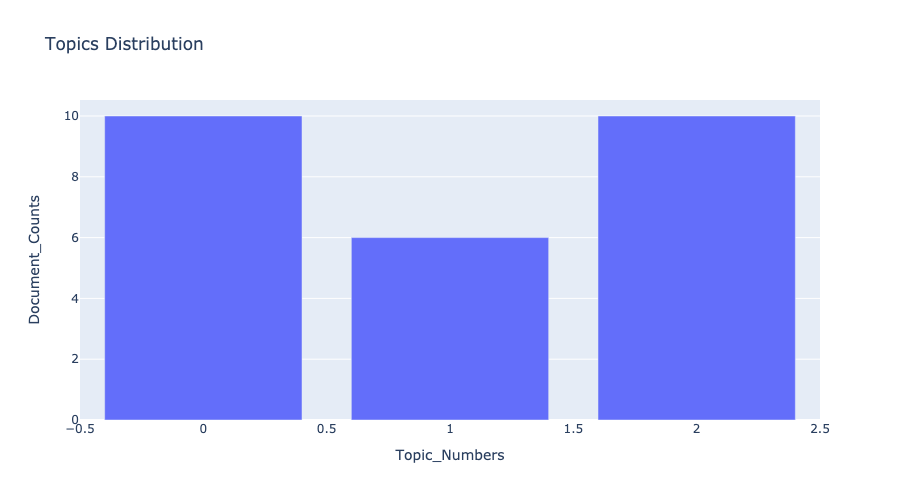

In [35]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()

In [42]:
pre_queries_dist

,Topic_Numbers,Document_Counts
0,2,10
1,0,10
2,1,6


In [36]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=2,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


Post-COVID coherence Score:  -4.405263418802653


In [37]:

import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.062156  0.0       1        1  53.461697
1     -0.062156  0.0       2        1  46.538303, topic_info=         Term       Freq      Total Category  logprob  loglift
125  business  31.000000  31.000000  Default  30.0000  30.0000
341    cheque  12.000000  12.000000  Default  29.0000  29.0000
336   account  37.000000  37.000000  Default  28.0000  28.0000
267   charges  16.000000  16.000000  Default  27.0000  27.0000
257  received  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
53   customer  10.170577  23.078830   Topic2  -5.6302  -0.0545
54       days  10.494229  29.289138   Topic2  -5.5988  -0.2615
320       day   9.265362  17.659351   Topic2  -5.7234   0.1199
139     month   9.911188  29.302810   Topic2  -5.6560  -0.3191
153       rbi   9.843086  33.190581   Topic2  -5.6629  -0.4506

[162 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
336       1  0.834061       account
336       2  0.161431       account
259       1  0.860766   application
259       2  0.172153   application
215       1  0.990781         apply
...     ...       ...           ...
279       2  0.481843            ur
1380      1  0.966191  village_want
318       1  0.493762          want
318       2  0.493762          want
1560      2  0.938568         years

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [38]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())


In [39]:

post_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['emi, loan, moratorium, account, business, mail, rbi, response, pay_emi, month',
       'loan, moratorium, emi, time, mail, reply, times, bank, dont, pay'],
      dtype=object)

Post-COVID two topics prevail:
1. Ask for moratorium
2. Issues with moratorium process

In [40]:
select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


array(['@Lendingkart Hi. My company has been in touch with a LendingKart representative. This rep has been extremely rude and unprofessional. Wanted to bring this to your notice. Please DM me for more details.',
       '@Lendingkart Makes people cibil score down by collecting their documents without providing any loan @PMOIndia @rsprasad @Anurag_Office',
       '@Lendingkart please stop sending SMS and emails.\nThanks',
       '@Lendingkart Your customer service is so screwed that you beat even the SBIs of the world. My loan got approved and for the last 18 days I have been chasing you guys to finalize the process &amp; disburse the amount, but to no avail. (Part 1)',
       '@Lendingkart And it\'s just impossible to talk to anyone in your team. The low-level execs are unimaginably rude and are available only at their convenience, and the only response you get by mailing to you is that "A ticket has been created". (Part 2)',
       '@Lendingkart I attached bank statement and rectified 

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



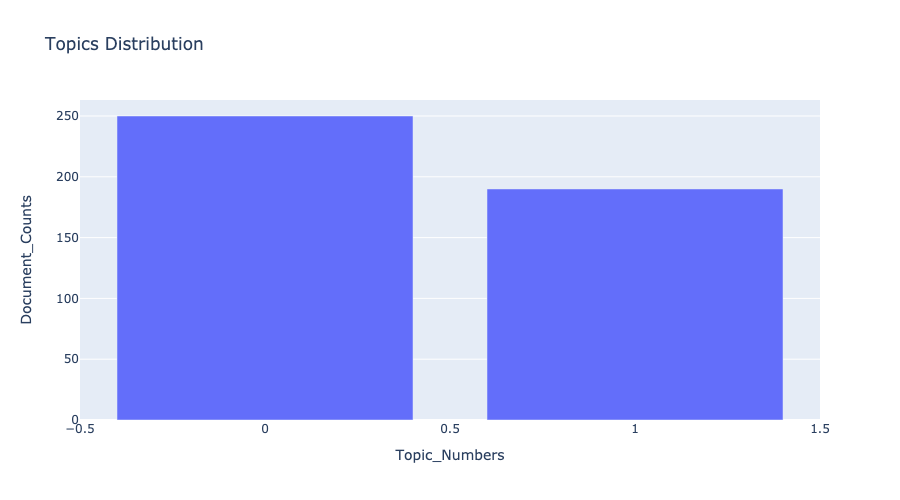

In [41]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()

In [43]:
post_queries_dist

,Topic_Numbers,Document_Counts
0,0,250
1,1,190
